In [732]:

import numpy as np         
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [733]:
fig_folder = "png"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# Data Reading

In [734]:
import pandas as pd

data = pd.read_csv('../data/train.csv')
print(f'The number of datapoints is {data.shape}')
data.head(5)

The number of datapoints is (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [735]:
data.info()     # display the data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Drop Null Data

In [736]:
data[data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [737]:
data = data.dropna()            # drop all rows with null values
data.shape

(404287, 6)

# Exploratory Data Analysis

## The distribution of duplicated questions

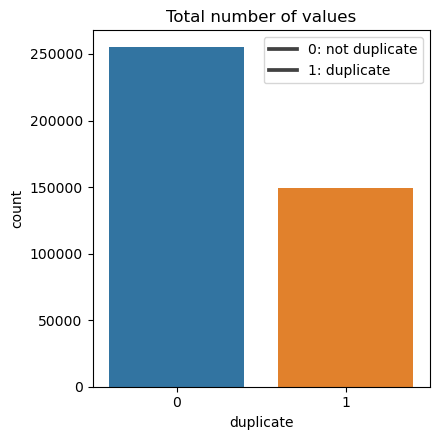

Total number of question pairs is 404287
Question pairs that are not similar is 255024 which is 63 % of total
Question pairs that are similar is 149263 which is 37 % of total


In [738]:
# plotting the number of duplicate pairs and different pairs
plt.figure(figsize=(4.5,4.5))
ct = data['is_duplicate'].value_counts() # create a dictionary to count different values of 'is_duplicate' column
sns.barplot(x=ct.index,y=ct.values)
plt.title('Total number of values')
plt.xlabel('duplicate')
plt.ylabel('count')
plt.legend(['0: not duplicate', '1: duplicate']) 
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'duplicate.png'), dpi=450)
plt.show()

print('Total number of question pairs is {}'.format(len(data.id.values)))
print('Question pairs that are not similar is {} which is {} % of total'.format(ct[0],round((ct[0]/(ct[1]+ct[0])*100)),2))
print('Question pairs that are similar is {} which is {} % of total'.format(ct[1],round((ct[1]/(ct[1]+ct[0])*100)),2))

In [739]:
ct

0    255024
1    149263
Name: is_duplicate, dtype: int64

## Uniques questions & Repeated questions

In [740]:
qids = pd.Series(data.qid2.tolist() + data.qid1.tolist()) # create a series of all the question ids
uniq = len(np.unique(qids)) # find the number of unique question ids
print('Total number of unique questions is {}'.format(uniq)) 
#Number of questions that repeated than 1 time
cnt = qids.value_counts()  # count the number of times each question occured 
more1 = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {} which is {:.2f}%'.format(more1,(more1/(len(cnt))*100)))
print('The maximum number of times a question occured is {}'.format(max(cnt)))

Total number of unique questions is 537929
Number of questions that repeated more than 1 time is 111778 which is 20.78%
The maximum number of times a question occured is 157


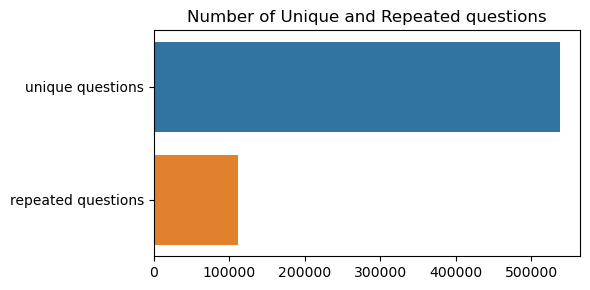

In [741]:
plt.figure(figsize=(6.0,3.0))
qts = pd.Series(data=['unique questions','repeated questions'], index=[uniq, more1])
sns.barplot(x=qts.index, y=qts.values)
plt.title('Number of Unique and Repeated questions')
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'Unique_repeated_quesions.png'), dpi=450)
plt.show()

In [742]:
# show top 5 popular questions
for qt in cnt[:5].index:
    if len(data[(data['qid1'] == qt)]['question1'].unique()):
        print(data[(data['qid1'] == qt)]['question1'].unique()[0])
    else:
        print(data[(data['qid2'] == qt)]['question2'].unique()[0])

What are the best ways to lose weight?
How can you look at someone's private Instagram account without following them?
How can I lose weight quickly?
What's the easiest way to make money online?
Can you see who views your Instagram?


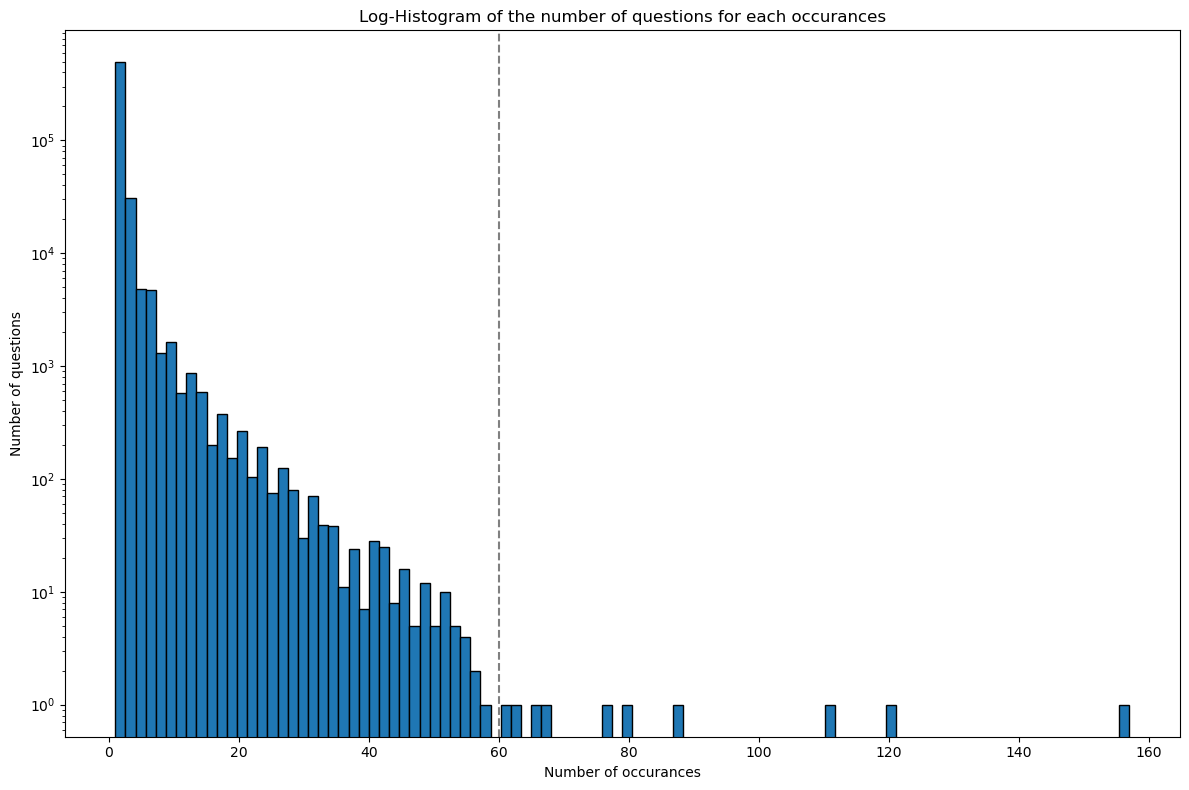

In [743]:
plt.figure(figsize=(12, 8))
plt.hist(qids.value_counts(),edgecolor='black',bins=100)
plt.axvline(x=60, color='gray', linestyle='--')
plt.yscale('log')
plt.title('Log-Histogram of the number of questions for each occurances')
plt.xlabel('Number of occurances')
plt.ylabel('Number of questions')
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'Log_Histogram_of_question_occurances.png'), dpi=450)
plt.show()

# Feature Engineering

We reconstruct the data and add some new features:
 - ____word_Common____ = (Number of unique common unique words in Question 1 and Question 2) -> The intersection of the two questions
  
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2) -> The union of the two questions
     
 - ____word_share____ = (word_common)/(word_Total), namely the similarity between the two questions. -> The similarity between the two questions


In [744]:
if os.path.isfile('data_with_out_preprocess.csv'):
    data = pd.read_csv("data_with_out_preprocess.csv",encoding='latin-1')
else:
    def common_wrd(row):
        x = set(row['question1'].lower().strip().split(" ")) 
        y = set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(x & y) # intersection of two sets


    def total(row):
        set1 = set(row['question1'].lower().strip().split(" "))
        set2 = set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2)) # union of two sets

    def word_share(row):
        x = row['word_common']/row['word_total']
        return  x # the ratio of common words to total words

data['word_common'] = data.apply(common_wrd,axis=1)
data['word_total'] = data.apply(total,axis=1)
data['word_share'] = data.apply(word_share,axis=1)
# save the data to csv file
data.to_csv("../data/data_with_out_preprocess.csv", index=False)

## New datasheet
As you can see, word_common, word_total, word_share are added to the original dataset.

In [745]:
data = pd.read_csv('../data/data_with_out_preprocess.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_common,word_total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,2.0,20.0,0.100000


### Common words between questions

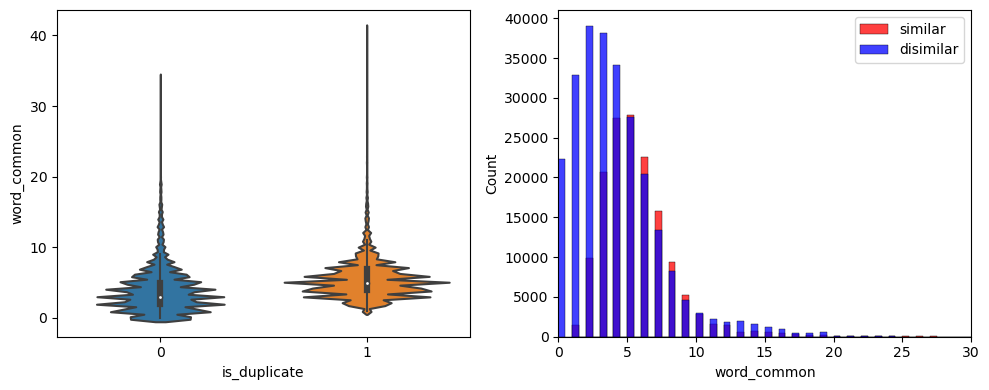

In [746]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=data)
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_common'],color='red',label='similar',binwidth=0.5)
sns.histplot(data[data['is_duplicate'] == 0]['word_common'],color='blue',label='disimilar',binwidth=0.5)
plt.legend()
plt.xlim(0,30)
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_common.png'), dpi=450)
plt.show()

### Shared words
From the following diagram, we can notice that as the word share increases there is a higher chance the questions are similar. From the histogram, we can understand that word share has some information differentiating similar and dissimilar classes. This trend matches the intuition that similar questions will have more words in common.

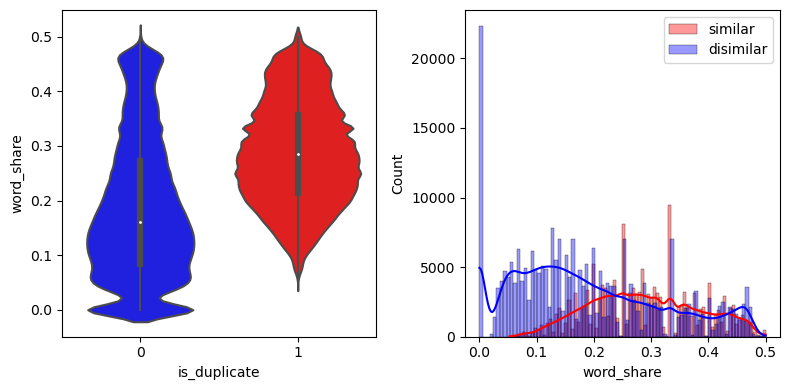

In [747]:
# plotting the relation between dulicate and word_share
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data,palette=['blue','red'])
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_share'],alpha = 0.4,color='red',kde=True, label='similar')
sns.histplot(data[data['is_duplicate'] == 0]['word_share'],alpha = 0.4,color='blue',kde=True, label='disimilar')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_share.png'), dpi=450)
plt.show()

### Plotting Word Clouds

Plotting Word Clouds help us to undertand important words/features.

### Text Preprocessing
As a part of text preprocessing, we performed the following steps:

- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [748]:
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [731]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  
    
    porter = PorterStemmer()    #apply stemming  for example, "cats" and "catlike" are reduced to "cat"
    pattern = re.compile('\W')  #remove special characters
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [751]:
data["question1"] = data["question1"].fillna("").apply(preprocess)
data["question2"] = data["question2"].fillna("").apply(preprocess)

In [750]:
print(data.head())
data_duplicate = data[data['is_duplicate'] == 1]
data_nonduplicate = data[data['is_duplicate'] == 0]

   id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate  \
0  what is the step by step guide to invest in sh...             0   
1  what would happen if the indian government sto...             0   
2  how can internet speed be increased by hacking...             0   
3  find the remainder when  math 23  24   math  i...             0   
4            which fish would survive in salt water              0   

   word_common  word_total  word_share  
0         10.0        23.0    0.434783  
1          4.0        20.0    0.200000  
2          4.0        2

In [702]:
sent_dup =np.dstack([data_duplicate['question1'].values,data_duplicate['question2'].values])
print(sent_dup[0])
print(sent_dup.shape)
# words_dup = [word for sublist in sent_dup for word in sublist]
words_dup = sent_dup.flatten()
print(words_dup[0])
print(words_dup.shape)
sent_ndup =np.dstack((data_nonduplicate['question1'].values,data_nonduplicate['question2'].values))
# words_ndup = [word for sublist in sent_ndup for word in sublist]
words_ndup = sent_ndup.flatten()

[['astrology  i am a capricorn sun cap moon and cap rising   what does that say about me '
  'i am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me ']
 ['how can i be a good geologist '
  'what should i do to be a great geologist ']
 ['how do i read and find my youtube comments '
  'how can i see all my youtube comments ']
 ...
 ['how does a long distance relationship work '
  'how are long distance relationships maintained ']
 ['what does jainism say about homosexuality '
  'what does jainism say about gays and homosexuality ']
 ['do you believe there is life after death '
  'is it true that there is life after death ']]
(1, 149263, 2)
astrology  i am a capricorn sun cap moon and cap rising   what does that say about me 
(298526,)


In [706]:
textp_w = words_dup
#open(path.join(d, 'train_p.txt')).read()
textn_w = words_ndup
#open(path.join(d, 'train_n.txt')).read()
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

textp_w = [str(i) for i in textp_w]
textn_w = [str(i) for i in textn_w]
print(textn_w[0])
textp_w = ''.join(textp_w)
textn_w = ''.join(textn_w)
print(textn_w[:100])

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510048
what is the step by step guide to invest in share market in india 
what is the step by step guide to invest in share market in india  what is the step by step guide to


### Word cloud for duplicate pair of questions

Word Cloud for Duplicate Question pairs


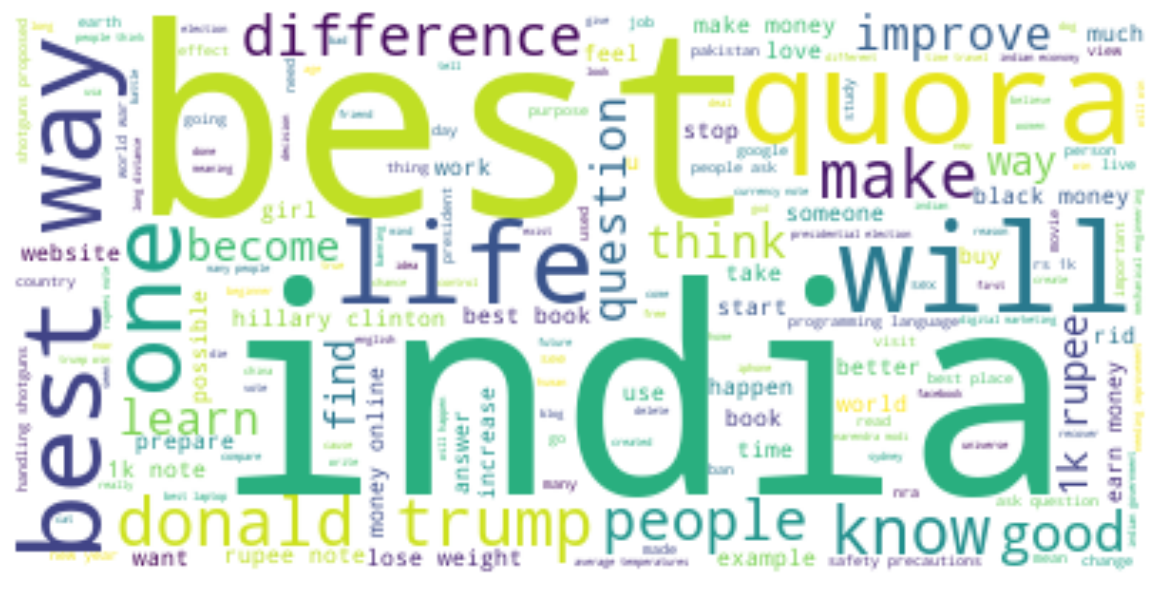

In [707]:
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white", max_words= len(textp_w), stopwords=stopwords)
# wc = WordCloud(background_color="white", max_words= 20, stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_clous_duplicate_pair.png'), dpi=450)
plt.show()

### Word cloud for non duplicate pair of questions

Word Cloud for Non Duplicate Question pairs


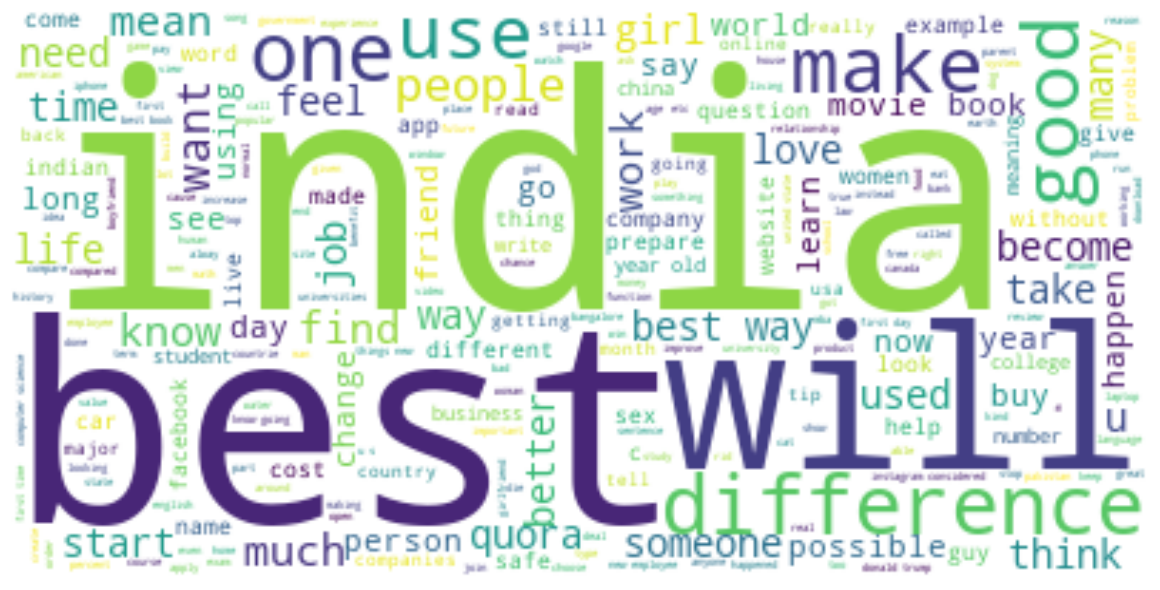

In [709]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
# wc = WordCloud(background_color="white", max_words= 20, stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_clous_non_duplicate_pair.png'), dpi=450)
plt.show()

# Minhashing and Locality Sensitive Hashing